In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
data = pd.read_csv('labelled_dataset.csv',index_col=0)

In [4]:
data.head(2)

,labels,body,parent,submission
0,supporting,no question want thank post topic birth contro...,updated september scroll downhi lengthy post c...,updated september scroll downhi lengthy post c...
1,supporting,holy shit thank much someone recently turn sup...,updated september scroll downhi lengthy post c...,updated september scroll downhi lengthy post c...


In [5]:
data.labels.value_counts()

commenting     614
supporting     299
denying        137
questioning    105
Name: labels, dtype: int64

In [56]:
# label weights
c = 13.5
s = 30.0
d = 70.0
q = 70.0

In [57]:
data.loc[data['labels'] == 'supporting', 'labels'] = 0
data.loc[data['labels'] == 'denying', 'labels'] = 1
data.loc[data['labels'] == 'questioning', 'labels'] = 2
data.loc[data['labels'] == 'commenting', 'labels'] = 3

In [58]:
data.head(2)

,labels,body,parent,submission
0,0,no question want thank post topic birth contro...,updated september scroll downhi lengthy post c...,updated september scroll downhi lengthy post c...
1,0,holy shit thank much someone recently turn sup...,updated september scroll downhi lengthy post c...,updated september scroll downhi lengthy post c...


In [59]:
labels = to_categorical(data['labels'], num_classes=4)
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [60]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['body'].values)
sequences = tokenizer.texts_to_sequences(data['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 4810 unique tokens.


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [62]:
epochs = 100
emb_dim = 128
batch_size = 32
labels[:2]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [63]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,class_weight={0:s,1:d,2:q,3:c},validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None
Train on 692 samples, validate on 174 samples
Epoch 1/100
692/692 [==============================] - 5s 7ms/step - loss: 39.7596 - acc: 0.2948 - val_loss: 38.8896 - val_acc: 0.2816
Epoch 2/100
692/692 [==============================] - 3s 4ms/step - loss: 39.

In [64]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

289/289 [==============================] - 0s 856us/step
Test set
  Loss: 1.097
  Accuracy: 0.543


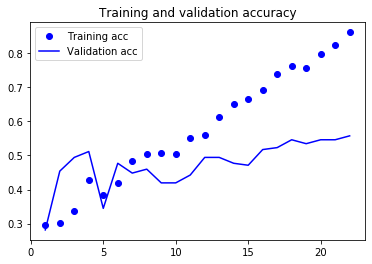

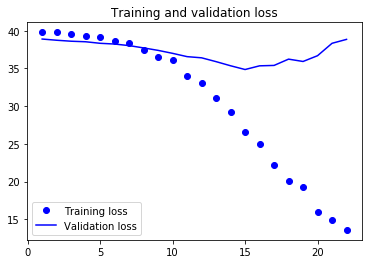

In [65]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [66]:
pred = model.predict(X_test)

In [67]:
ary = []
lb = ['supporting', 'denying', 'questioning', 'commenting']
for i in range(pred.shape[0]):
    ary.append(lb[np.argmax(pred[i])])

In [68]:
sup = [1.,0.,0.,0.]
den = [0.,1.,0.,0.]
que = [0.,0.,1.,0.]
com = [0.,0.,0.,1.]

In [69]:
list(y_test[0])

[0.0, 0.0, 0.0, 1.0]

In [70]:
test = []
for i in range(y_test.shape[0]):
    if( list(y_test[i]) == sup ):
        test.append('supporting')
    elif( list(y_test[i]) == den ):
        test.append('denying')
    elif( list(y_test[i]) == que ):
        test.append('questioning')
    else:
        test.append('commenting')


In [71]:
results = pd.DataFrame(test)
results.columns = ['test']
results['predictions'] = ary

In [72]:
results.head()

,test,predictions
0,commenting,commenting
1,commenting,questioning
2,commenting,commenting
3,denying,commenting
4,denying,denying


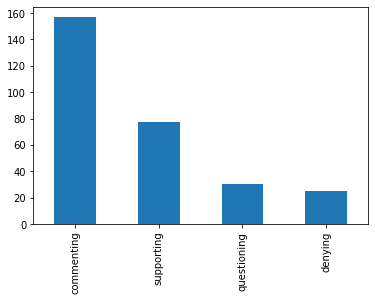

In [73]:
results.predictions.value_counts().plot(kind='bar')

In [74]:
results.predictions.value_counts()

commenting     157
supporting      77
questioning     30
denying         25
Name: predictions, dtype: int64

In [75]:
correct = []
for i in range(results.shape[0]):
    ans = False
    if(results['test'][i] ==  results['predictions'][i]):
        ans = True
    correct.append(ans)
results['result'] = correct

In [76]:
results.result.value_counts()

True     157
False    132
Name: result, dtype: int64

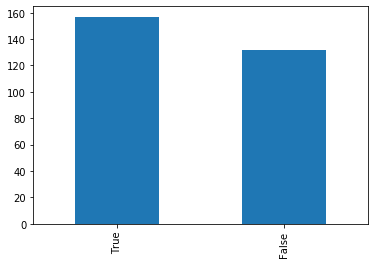

In [77]:
results.result.value_counts().plot(kind='bar')